# 1. MNIST classification with a fully connected neural network

Made in 2023  by [Léonard Seydoux](https://sites.google.com/view/leonard-seydoux/accueil) for the [Short Course #3](https://spin-itn.eu/sc3/) of the [Innovative Training Network SPIN](https://spin-itn.eu/) (Seismological Parameters and INstrumentation).

This notebook is part of the classes on neural networks and applications to seismic data analysis. The example here uses a fully connected neural network to classify images from the MNIST dataset (not seismological, yet). This notebook is freely adapted from [MilindMalshe's repository](https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py).

## 1. Introduction

### 1.1. Objectives

__The goal of this notebook is to train this network on the MNIST dataset and to evaluate its performance, and find ways to improve it with playing with the hyperparameters.__

More specifically, we would like to understand how many hidded layers, and how many neurons per hidden layer, are needed to achieve a good performance on the MNIST dataset. What are the good settings for the batch size, the learning rate, and the number of epochs? How does the performance of the network change when we use a different activation function? How does the performance of the network change when we use a different loss function?

If we were to define a leaderboard for this problem, we would like to keep only the results that show up with an accuracy of at least 95% on the test set. We would also like to keep only the results that show up with a training time of at most 5 minutes, and with the least number of parameters. Finding all appropriate plots to solve these questions are welcome.

### 1.2 Imports and configuration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

import models

ModuleNotFoundError: No module named 'torch'

In [2]:
%config InlineBackend.figure_formats = "svg"

## 2. The MNIST dataset

### 2.2 Downloading the dataset

**First, we need to download the MNIST dataset.** This can be done using the `torchvision.datasets.MNIST` class. This class can download and read the dataset in a single line of code. The dataset will be downloaded to a specific `DATA_DIRECTORY` directory (please, take time to set this value to a convenient location for you). 

The `train` argument specifies whether we want to download the train set or the test set. The `download=True` argument specifies that we want to download the dataset if it is not already available. After downloading the data, executing again this cell won't download it again. The `transform` argument specifies the image transformations that we want to apply to the images. In this case, we will convert the images to PyTorch tensors in order to allow for communication between the data and the inner matrices of the model. This is a very important step, because the neural network expects the input data to be in the form of tensors.

In [3]:
DATA_DIRECTORY = "./data"

# Download the MNIST train dataset
# For the first download, please turn on download=True
train_dataset = torchvision.datasets.MNIST(
    root=DATA_DIRECTORY,
    train=True,
    transform=transforms.ToTensor(),
)

# Download the MNIST test dataset
# For the first download, please turn on download=True
test_dataset = torchvision.datasets.MNIST(
    root=DATA_DIRECTORY,
    train=False,
    transform=transforms.ToTensor(),
)

### 2.2 Visualize some of the images in the dataset

This stage is simply to get a feeling of the dataset. If you would like to visualize more images, you can change the value of the `ncols` and `nrows`. Note that generating many subplots can take some time with matplotlib. 

The original images were binary (i.e., pixels of either zeros or ones) and of various size. In order to simplify the training, LeCun and collaborators decided to low-pass filter the images with a Gaussian filter before resampling them to 28 x 28 pixels. This introduced the small blur effect that we can observe on the digits. 

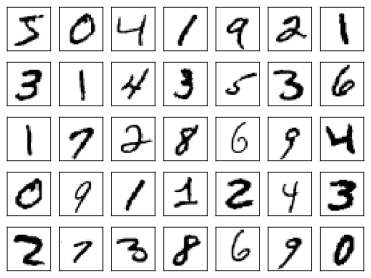

In [4]:
# Generate subplots
fig, ax = plt.subplots(ncols=7, nrows=5)
for i, ax in enumerate(ax.flatten()):

    # Extract image and label
    digit_image = train_dataset.data[i].numpy()
    digit_label = train_dataset.targets[i].numpy()

    # Show
    ax.matshow(digit_image, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

## 3. Define the model

### 3.1 Find the device to run the model on

Neural networks, as well as many other machine learning algorithms, are computationally intensive. Therefore, it is important to use a GPU to speed up the training process. Alhtought, this is not always easy to access a GPU. The good thing about PyTorch is that it can run on CPU as well. So, we will first check if a GPU is available and use it if it is. Otherwise, we will use the CPU. This can be later used to run the code on a GPU if you find one in the end.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {str(device).upper()} device.")

Running on CUDA device.


### 3.2 Model hyperparameters and initialization

- `INPUT_SIZE` and `N_CLASSES` are the size of the input layer and the number of classes, respectively. These are not hyperparameters _per se_, but it is a good practice to define them as a constants. 
- `HIDDEN_SIZE` is the number of units of the hidden layer. Note that in our case, we used only a single hidden layer, and this may not be the best choice.
- `EPOCHS` is the number of epochs used to train the model. An epoch defines the training process over the whole dataset.
- `BATCH_SIZE` is the size of the batch used during training, i.e. the number of images used to update the model parameters at each iteration.
- `LEARNING_RATE` is the learning rate of the optimizer, i.e. the step size used to update the model parameters at each iteration.

Please, take the time to look at the model definition in the `models.py`. You will find there some explanation of the different functions (or methods) to define in order to write a neural network. If unclear, we should spend time on this stage.

In [6]:
INPUT_SIZE = 28 * 28
N_CLASSES = 10
HIDDEN_SIZE = 3
EPOCHS = 5
LEARNING_RATE = 1
BATCH_SIZE = 5

# Define the model
model = models.MultiLayerPerceptron(INPUT_SIZE, HIDDEN_SIZE, N_CLASSES)
model = model.to(device)

# Meta information
trainable_parameters = sum([p.numel() for p in model.parameters()])
print(model)
print(f"Number of trainable parameters: {trainable_parameters}")

MultiLayerPerceptron(
  (linear_1): Linear(in_features=784, out_features=3, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=3, out_features=10, bias=True)
  (activation_2): Softmax(dim=1)
)
Number of trainable parameters: 2395


### 3.3 Define the loss function and the optimizer

The loss function is used to evaluate the performance of the model. The optimizer is used to update the model parameters. In our case, we will use the mean squared error loss function and the stochastic gradient descent optimizer. Of course, this is not meant to be the best choice, and you can try to change them and see how it affects the performance of the model.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

## 4. Train the model

### 4.1. Define the data loader

This stage is often underestimated. The data loader is the part of the code that loads the data from the disk and prepares it for the neural network. This is a very important part of the code, because it can have a huge impact on the performance of the neural network. In this case, we will use the `DataLoader` class from PyTorch to load the data. This class is very flexible and can be used to load various types data in many different ways. In the present case, we will use it to load the data into batches, enabling stochastic gradient descent (SGD).

At this stage, the batch size is the only meta-parameter that we need to set. This is the number of images that will be loaded into memory at a time. The batch size is a very important hyper-parameter that can have a huge impact on the performance of the neural network. In general, the larger the batch size, the faster the training process. However, the batch size should not be too large, because it can cause the GPU to run out of memory. In this case, we will use a batch size of 100. This is a good starting point, but it can be changed later to see how it affects the performance of the neural network.

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

### 4.2. Training loop

In order to feed the model with images, we need to reshape them into a vector, i.e. a 1D array. This is because a fully-connected model expects the input data to be in the form of a vector. We use the `reshape` method to do this.

__Note__: if you relaunch the cell, you will start over from the previous state.

Epoch 1/5:   0%|          | 0/12000 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/12000 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/12000 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/12000 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/12000 [00:00<?, ?it/s]

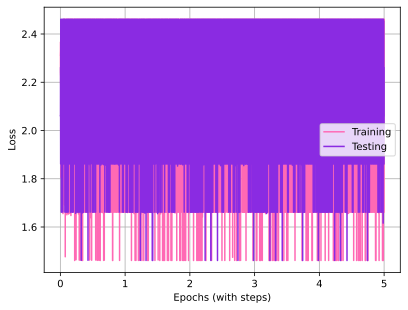

In [9]:
# Initialization
steps = len(train_loader)
loss_train, loss_test = [], []
fig = plt.figure()
ax = plt.axes()

for epoch in range(EPOCHS):

    description = f"Epoch {epoch + 1}/{EPOCHS}"

    for images, labels in tqdm(train_loader, total=steps, desc=description):

        # Move tensors to the configured device and reshape
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())

        # Set the gradients to zero before starting to do backpropragation
        # because PyTorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()

        # Calculate the gradients by performing a backward pass and update
        loss.backward()
        optimizer.step()

    # Test the model (don't need to compute gradients)
    with torch.no_grad():

        for images, labels in test_loader:

            # Move tensors to the configured device
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_test.append(loss.item())

    # Plot loss
    ax.cla()
    epochs_train = np.linspace(0, epoch + 1, len(loss_train))
    epochs_test = np.linspace(0, epoch + 1, len(loss_test))
    ax.plot(epochs_train, loss_train, label="Training", color="hotpink")
    ax.plot(epochs_test, loss_test, label="Testing", color="blueviolet")
    ax.legend()
    ax.grid()
    ax.set_xlabel("Epochs (with steps)")
    ax.set_ylabel("Loss")
    fig.savefig("loss_fcnn.png", bbox_inches="tight")


### 4.3 Save the model checkpoint

We will save the model checkpoint after training. This will allow us to load the model later without having to train it again. This is very useful when we want to experiment with the model, or when we want to use it for inference.

Do not forget to rename the file when trying a new experiment. If better, you can set up automatic renaming of this file depending on the parameters for instance.

In [10]:
torch.save(model.state_dict(), "models/fcnn.ckpt")

## 5. Model performance

### 5.1 Random model guesses

We here select a random sample from the last test mini batch and observe the prediction. You can run this cell and observe various predictions. Do you get the the reasons for the mistaken digits?

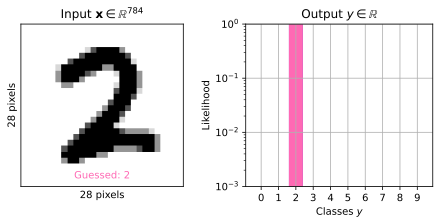

In [11]:
index = np.random.randint(images.shape[0])

# Extract x and y
x = images[index].reshape(28, 28).cpu()
h = outputs.cpu().numpy()[index]
y = h.argmax()

# Get all categories
classes = range(len(h))

with plt.rc_context({"figure.constrained_layout.use": True}):
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    # Image
    ax[0].imshow(x, cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("28 pixels")
    ax[0].set_ylabel("28 pixels")
    ax[0].set_title(r"Input $\mathbf{x} \in \mathbb{R}^{784}$")
    ax[0].text(0.5, 0.05, f"Guessed: {y}", transform=ax[0].transAxes, ha="center", color="hotpink")

    # Probability
    ax[1].bar(classes, h, color="blueviolet")
    ax[1].bar(classes[y], height=h[y], color="hotpink")
    ax[1].set_xticks(classes)
    ax[1].grid()
    ax[1].set_yscale("log")
    ax[1].set_ylim(1e-3, 1)
    ax[1].set_ylabel("Likelihood")
    ax[1].set_xlabel("Classes $y$")
    ax[1].set_title(r"Output $y \in \mathbb{R}$")

### 5.2 Confusion and accuracy

For classification tasks, the accuracy is a relevant metric to evaluate the performance of the model. The accuracy is defined as the number of correct predictions divided by the total number of predictions. In our case, we will use the accuracy to evaluate the performance of the model on the test set. 

We can also represent the confusion matrix. This is a matrix that shows the number of correct and incorrect predictions for each class. The diagonal of the matrix shows the number of correct predictions, while the off-diagonal elements show the number of incorrect predictions. The confusion matrix can be used to identify the classes that are more difficult to classify, and therefore to tune up the model.

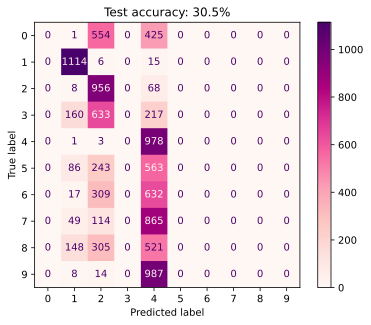

In [12]:
with torch.no_grad():

    labels_true = []
    labels_pred = []

    for images, labels in test_loader:

        # Calcualate predictions on the test set
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)

        # Store predictions and true labels
        labels_pred.extend(predicted.cpu().numpy())
        labels_true.extend(labels.cpu().numpy())

# Calculate confusion matrix and accuracy
confusion = confusion_matrix(labels_true, labels_pred)
accuracy = np.diag(confusion).sum() / confusion.sum()

# Show
ConfusionMatrixDisplay(
    confusion_matrix=confusion,
    display_labels=range(N_CLASSES),

).plot(cmap="RdPu")
plt.title(f"Test accuracy: {accuracy:.1%}")
plt.show()


### 5.3 Other plots

We can also visualize some images and see how the model performs on them. This is a good way to get a feeling of the model performance. If you would like to visualize more images, you can change the value of the `ncols` and `nrows`. Note that generating many subplots can take some time with matplotlib.

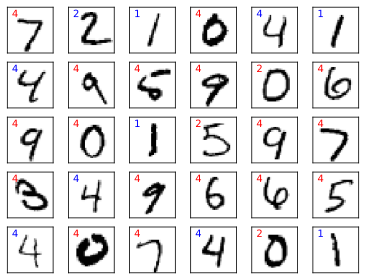

In [13]:
# Figure instance
fig, ax = plt.subplots(ncols=6, nrows=5)

for i, ax in enumerate(ax.flatten()):

    # Extract image
    digit_image = test_dataset.data[i].numpy()
    digit_label = test_dataset.targets[i].numpy()
    predicted_label = labels_pred[i]

    # Case-dependant color
    color = "blue" if digit_label == predicted_label else "red"

    # Show
    # Show
    ax.matshow(digit_image, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
    text_kwargs = dict(va="top", ha="left", transform=ax.transAxes)
    ax.text(0.1, 0.95, predicted_label, color=color, **text_kwargs)

## Furhter points

- __Lower number of parameters__: most configurations enable you to quicky reach an accuracty of 96%. But accuracy (or error) is not always the only target. We can also imagine application with tolerated errors at much lower computational costs. How would you do (in the next cell for instance) to look for the smallest possible architecture with lowest number of parameters?

- __Fastest convergence__: another way of reducing the computational cost is to ensure that the model converges fast towards an acceptable minimum. What strategies would seem interesting ot you, and what part of the network do you think you should work on to achieve faster convergence?